In [ ]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from quantile_forest import RandomForestQuantileRegressor
from sklearn.base import BaseEstimator, RegressorMixin

from deel.puncc.api.prediction import DualPredictor
from deel.puncc.regression import CQR
from deel.puncc.metrics import regression_mean_coverage, regression_sharpness


from deel.puncc.api.prediction import BasePredictor
from deel.puncc.regression import EnbPI

from deel.puncc.api.prediction import BasePredictor
from deel.puncc.regression import EnbPI, AdaptiveEnbPI
from deel.puncc.api.prediction import MeanVarPredictor


In [3]:

# 1) Carga y partición temporal (tu mismo código)
df = pd.read_csv("data_loads_final.csv")
df["TIMESTAMP"] = pd.to_datetime(df["TIMESTAMP"])

test_start = pd.Timestamp("2010-12-09 23:00:00")
test_end   = pd.Timestamp("2011-12-09 23:00:00")
val_start  = pd.Timestamp("2009-12-09 23:00:00")

df_test  = df[(df["TIMESTAMP"] >= test_start) & (df["TIMESTAMP"] <= test_end)]
df_val   = df[(df["TIMESTAMP"] >= val_start)  & (df["TIMESTAMP"] <  test_start)]
df_train = df[df["TIMESTAMP"] < val_start]

In [4]:
# 2) Features / target 
excluded_cols = ['LOAD', 'TIMESTAMP', 'ZONEID', 'Task']
feature_cols  = [c for c in df.columns if c not in excluded_cols]

X_train, y_train = df_train[feature_cols], df_train['LOAD']
X_val,   y_val   = df_val[feature_cols],   df_val['LOAD']
X_test,  y_test  = df_test[feature_cols],  df_test['LOAD']
t_test           = df_test['TIMESTAMP'].reset_index(drop=True)

print(f"Shapes → train: {X_train.shape}, calib: {X_val.shape}, test: {X_test.shape}")

Shapes → train: (43293, 68), calib: (8760, 68), test: (8547, 68)


In [5]:
class QRFQuantile(BaseEstimator, RegressorMixin):
    def __init__(self, quantile, n_estimators=77, max_depth=120,
                 max_features=0.7, min_samples_leaf=6, random_state=42, n_jobs=-1, **kw):
        self.quantile = quantile
        self.kw = dict(n_estimators=n_estimators, max_depth=max_depth,
                       max_features=max_features, min_samples_leaf=min_samples_leaf,
                       random_state=random_state, n_jobs=n_jobs, **kw)
    def fit(self, X, y):
        self.model_ = RandomForestQuantileRegressor(**self.kw).fit(X, y)
        return self
    def predict(self, X):
        return np.asarray(self.model_.predict(X, quantiles=[self.quantile])).ravel()

In [ ]:



regressor_q_low = QRFQuantile(quantile=0.10) 
regressor_q_hi  = QRFQuantile(quantile=0.90)  

#  Wrap models in predictor (igual que el ejemplo)
predictor = DualPredictor(models=[regressor_q_low, regressor_q_hi])

#  CP method initialization (CQR)
crq = CQR(predictor)

#  Fit (entrena y calcula nonconformity en el set de calibración)
crq.fit(X_fit=X_train, y_fit=y_train, X_calib=X_val, y_calib=y_val)

#  Predict (intervalos al 80% -> alpha=.2)
y_pred, y_pred_lower, y_pred_upper = crq.predict(X_test, alpha=.2)


In [ ]:
# Compute marginal coverage and average width of the prediction intervals
coverage = regression_mean_coverage(y_test, y_pred_lower, y_pred_upper)
width = regression_sharpness(y_pred_lower=y_pred_lower,
                             y_pred_upper=y_pred_upper)
print(f"Marginal coverage: {np.round(coverage, 2)}")
print(f"Average width: {np.round(width, 2)}")

coverage_80 = coverage
width_80 = width

Marginal coverage: 0.8
Average width: 34.85


In [16]:
regressor_q_low = QRFQuantile(quantile=0.05) 
regressor_q_hi  = QRFQuantile(quantile=0.95)  

#  Wrap models in predictor (igual que el ejemplo)
predictor = DualPredictor(models=[regressor_q_low, regressor_q_hi])

#  CP method initialization (CQR)
crq = CQR(predictor)

#  Fit (entrena y calcula nonconformity en el set de calibración)
crq.fit(X_fit=X_train, y_fit=y_train, X_calib=X_val, y_calib=y_val)

#  Predict (intervalos al 80% -> alpha=.2)
y_pred, y_pred_lower, y_pred_upper = crq.predict(X_test, alpha=.1)

# Compute marginal coverage and average width of the prediction intervals
coverage = regression_mean_coverage(y_test, y_pred_lower, y_pred_upper)
width = regression_sharpness(y_pred_lower=y_pred_lower,
                             y_pred_upper=y_pred_upper)
print(f"Marginal coverage: {np.round(coverage, 2)}")
print(f"Average width: {np.round(width, 2)}")

coverage_90 = coverage
width_90 = width

Marginal coverage: 0.9
Average width: 45.6


In [18]:
regressor_q_low = QRFQuantile(quantile=0.02) 
regressor_q_hi  = QRFQuantile(quantile=0.98)  

#  Wrap models in predictor (igual que el ejemplo)
predictor = DualPredictor(models=[regressor_q_low, regressor_q_hi])

#  CP method initialization (CQR)
crq = CQR(predictor)

#  Fit (entrena y calcula nonconformity en el set de calibración)
crq.fit(X_fit=X_train, y_fit=y_train, X_calib=X_val, y_calib=y_val)

#  Predict (intervalos al 80% -> alpha=.2)
y_pred, y_pred_lower, y_pred_upper = crq.predict(X_test, alpha=.04)

# Compute marginal coverage and average width of the prediction intervals
coverage = regression_mean_coverage(y_test, y_pred_lower, y_pred_upper)
width = regression_sharpness(y_pred_lower=y_pred_lower,
                             y_pred_upper=y_pred_upper)
print(f"Marginal coverage: {np.round(coverage, 2)}")
print(f"Average width: {np.round(width, 2)}")

coverage_96 = coverage
width_96 = width

Marginal coverage: 0.96
Average width: 59.34


## EnPI

Types: <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
Shapes: (52053, 68) (52053,) (8547, 68)
EnbPI(QRF@0.5) — alpha=0.20 | coverage=0.719 | mean width=25.336


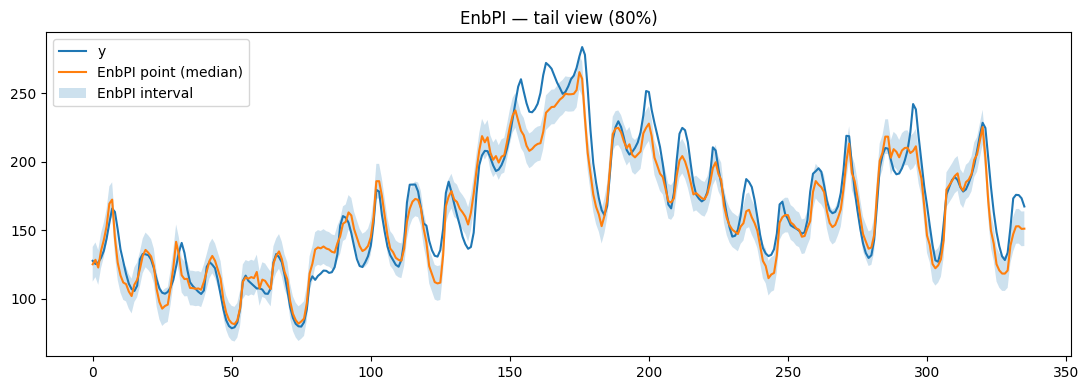

In [ ]:
# 0) Build FIT data (TRAIN + VAL)
X_fit_df = pd.concat([X_train, X_val], axis=0)
y_fit_sr = pd.concat([y_train, y_val], axis=0)

# --- convert to NumPy to avoid pandas column selection in EnbPI
X_fit  = X_fit_df.to_numpy()
y_fit  = y_fit_sr.to_numpy().reshape(-1)
X_test_np = X_test.to_numpy()
y_test_np = y_test.to_numpy().reshape(-1)

# 1) Base model: QRF median (point predictor)
qrf_median = QRFQuantile(
    quantile=0.50)

# 2) Wrap & EnbPI (params unchanged)
base_pred = BasePredictor(qrf_median)
enbpi = EnbPI(
    base_pred,
    B=30,
    agg_func_loo=np.mean,
    random_state=0,
)

# 3) Fit on arrays
enbpi.fit(X_fit, y_fit)

# 4) Predict (80% example)
alpha = 0.20
y_pred, y_lo, y_hi = enbpi.predict(
    X_test_np, alpha=alpha, y_true=y_test_np, s=None
)

# ensure 1D
y_pred = np.asarray(y_pred).ravel()
y_lo   = np.asarray(y_lo).ravel()
y_hi   = np.asarray(y_hi).ravel()

# 5) Metrics
cov = regression_mean_coverage(y_test_np, y_lo, y_hi)
wid = regression_sharpness(y_pred_lower=y_lo, y_pred_upper=y_hi)
print(f"EnbPI(QRF@0.5) — alpha={alpha:.2f} | coverage={cov:.3f} | mean width={wid:.3f}")


# 6) Quick tail plot (indices on x-axis to keep it simple)
K = min(336, len(y_test))
x = np.arange(K)
plt.figure(figsize=(11,4))
plt.plot(x, y_test.values[-K:], label="y")
plt.plot(x, y_pred[-K:],       label="EnbPI point (median)")
plt.fill_between(x, y_lo[-K:], y_hi[-K:], alpha=0.22, label="EnbPI interval")
plt.title("EnbPI — tail view (80%)")
plt.legend(); plt.tight_layout(); plt.show()




In [ ]:
def eval_enbpi(B, agg_func_loo=np.mean, alphas=(0.20, 0.10, 0.04)):
    
    enbpi = EnbPI(base_pred, B=B, agg_func_loo=agg_func_loo, random_state=0)
    enbpi.fit(X_fit, y_fit)
    rows = []
    for a in alphas:
        y_pred, y_lo, y_hi = enbpi.predict(X_test_np, alpha=a, y_true=y_test_np, s=None)
        cov = regression_mean_coverage(y_test_np, y_lo, y_hi)
        wid = regression_sharpness(y_pred_lower=y_lo, y_pred_upper=y_hi)
        rows.append({"B": B, "agg": getattr(agg_func_loo, "__name__", "custom"),
                     "nominal": 1-a, "empirical": cov, "width": wid})
    return pd.DataFrame(rows)

# Small grid over B (keep it quick; expand later if needed)
results = pd.concat([eval_enbpi(B) for B in [30, 50, 100]], ignore_index=True)
print(results)

     B   agg  nominal  empirical      width
0   30  mean     0.80   0.719083  25.335833
1   30  mean     0.90   0.825553  34.536667
2   30  mean     0.96   0.921493  46.600000
3   50  mean     0.80   0.716158  25.210316
4   50  mean     0.90   0.827191  34.559579
5   50  mean     0.96   0.920440  46.462469
6  100  mean     0.80   0.717913  25.180329
7  100  mean     0.90   0.827542  34.488050
8  100  mean     0.96   0.919621  46.344956


In [ ]:
def eval_enbpi(B, agg_func_loo=np.mean, alphas=(0.20, 0.10, 0.04)):
    
    enbpi = EnbPI(base_pred, B=B, agg_func_loo=agg_func_loo, random_state=0)
    enbpi.fit(X_fit, y_fit)
    rows = []
    for a in alphas:
        y_pred, y_lo, y_hi = enbpi.predict(X_test_np, alpha=a, y_true=y_test_np, s=None)
        cov = regression_mean_coverage(y_test_np, y_lo, y_hi)
        wid = regression_sharpness(y_pred_lower=y_lo, y_pred_upper=y_hi)
        rows.append({"B": B, "agg": getattr(agg_func_loo, "__name__", "custom"),
                     "nominal": 1-a, "empirical": cov, "width": wid})
    return pd.DataFrame(rows)

# Small grid over B (keep it quick; expand later if needed)
results = pd.concat([eval_enbpi(B) for B in [200]], ignore_index=True)
print(results)

     B   agg  nominal  empirical      width
0  200  mean     0.80   0.715456  25.153882
1  200  mean     0.90   0.827893  34.497404
2  200  mean     0.96   0.920908  46.402527


In [ ]:
X_fit_df = pd.concat([X_train, X_val], axis=0)
y_fit_sr = pd.concat([y_train, y_val], axis=0)
X_fit     = X_fit_df.to_numpy()
y_fit     = y_fit_sr.to_numpy().reshape(-1)
X_test_np = X_test.to_numpy()
y_test_np = y_test.to_numpy().reshape(-1)

# Mean (mu) and dispersion (sigma) models
mu_model    = QRFQuantile(quantile=0.50, random_state=42)
sigma_model = QRFQuantile(quantile=0.90, random_state=123)

# Wrap them for AdaptiveEnbPI
mv_pred = MeanVarPredictor([mu_model, sigma_model])

# AdaptiveEnbPI with B = 100
aenbpi = AdaptiveEnbPI(mv_pred, B=100, agg_func_loo=np.mean, random_state=0)

# Fit
aenbpi.fit(X_fit, y_fit)

# Evaluate a few alphas
alphas = [0.20, 0.10, 0.04]
for a in alphas:
    y_pred, y_lo, y_hi = aenbpi.predict(X_test_np, alpha=a, y_true=y_test_np, s=None)
    cov  = regression_mean_coverage(y_test_np, y_lo, y_hi)
    wid  = regression_sharpness(y_pred_lower=y_lo, y_pred_upper=y_hi)
    print(f"alpha={a:.2f} | nominal={1-a:.2f} | empirical={cov:.3f} | width={wid:.3f}")


alpha=0.20 | nominal=0.80 | empirical=0.702 | width=25.107
alpha=0.10 | nominal=0.90 | empirical=0.803 | width=31.385
alpha=0.04 | nominal=0.96 | empirical=0.881 | width=38.411


In [21]:
sigma_model = QRFQuantile(quantile=0.95, random_state=123)

# Wrap them for AdaptiveEnbPI
mv_pred = MeanVarPredictor([mu_model, sigma_model])

# AdaptiveEnbPI with B = 100
aenbpi = AdaptiveEnbPI(mv_pred, B=100, agg_func_loo=np.mean, random_state=0)

# Fit
aenbpi.fit(X_fit, y_fit)

# Evaluate a few alphas
alphas = [0.20, 0.10, 0.04]
for a in alphas:
    y_pred, y_lo, y_hi = aenbpi.predict(X_test_np, alpha=a, y_true=y_test_np, s=None)
    cov  = regression_mean_coverage(y_test_np, y_lo, y_hi)
    wid  = regression_sharpness(y_pred_lower=y_lo, y_pred_upper=y_hi)
    print(f"alpha={a:.2f} | nominal={1-a:.2f} | empirical={cov:.3f} | width={wid:.3f}")

alpha=0.20 | nominal=0.80 | empirical=0.707 | width=25.399
alpha=0.10 | nominal=0.90 | empirical=0.810 | width=31.934
alpha=0.04 | nominal=0.96 | empirical=0.886 | width=39.013


In [22]:
sigma_model = QRFQuantile(quantile=0.98, random_state=123)

# Wrap them for AdaptiveEnbPI
mv_pred = MeanVarPredictor([mu_model, sigma_model])

# AdaptiveEnbPI with B = 100
aenbpi = AdaptiveEnbPI(mv_pred, B=100, agg_func_loo=np.mean, random_state=0)

# Fit
aenbpi.fit(X_fit, y_fit)

# Evaluate a few alphas
alphas = [0.20, 0.10, 0.04]
for a in alphas:
    y_pred, y_lo, y_hi = aenbpi.predict(X_test_np, alpha=a, y_true=y_test_np, s=None)
    cov  = regression_mean_coverage(y_test_np, y_lo, y_hi)
    wid  = regression_sharpness(y_pred_lower=y_lo, y_pred_upper=y_hi)
    print(f"alpha={a:.2f} | nominal={1-a:.2f} | empirical={cov:.3f} | width={wid:.3f}")

alpha=0.20 | nominal=0.80 | empirical=0.714 | width=25.660
alpha=0.10 | nominal=0.90 | empirical=0.815 | width=32.495
alpha=0.04 | nominal=0.96 | empirical=0.893 | width=39.907


In [ ]:
sigma_model = QRFQuantile(quantile=0.5, random_state=123)

# Wrap them for AdaptiveEnbPI
mv_pred = MeanVarPredictor([mu_model, sigma_model])

# AdaptiveEnbPI with B = 100
aenbpi = AdaptiveEnbPI(mv_pred, B=100, agg_func_loo=np.mean, random_state=0)

# Fit
aenbpi.fit(X_fit, y_fit)

# Evaluate a few alphas
alphas = [0.20, 0.10, 0.04]
for a in alphas:
    y_pred, y_lo, y_hi = aenbpi.predict(X_test_np, alpha=a, y_true=y_test_np, s=None)
    cov  = regression_mean_coverage(y_test_np, y_lo, y_hi)
    wid  = regression_sharpness(y_pred_lower=y_lo, y_pred_upper=y_hi)
    print(f"alpha={a:.2f} | nominal={1-a:.2f} | empirical={cov:.3f} | width={wid:.3f}")

alpha=0.20 | nominal=0.80 | empirical=0.670 | width=24.248
alpha=0.10 | nominal=0.90 | empirical=0.767 | width=30.940


In [10]:
mu_model    = QRFQuantile(quantile=0.50, random_state=42)
sigma_model = QRFQuantile(quantile=0.02, random_state=123)

# Wrap them for AdaptiveEnbPI
mv_pred = MeanVarPredictor([mu_model, sigma_model])

# AdaptiveEnbPI with B = 100
aenbpi = AdaptiveEnbPI(mv_pred, B=100, agg_func_loo=np.mean, random_state=0)

# Fit
aenbpi.fit(X_fit, y_fit)

# Evaluate a few alphas
alphas = [0.20, 0.10, 0.04]
for a in alphas:
    y_pred, y_lo, y_hi = aenbpi.predict(X_test_np, alpha=a, y_true=y_test_np, s=None)
    cov  = regression_mean_coverage(y_test_np, y_lo, y_hi)
    wid  = regression_sharpness(y_pred_lower=y_lo, y_pred_upper=y_hi)
    print(f"alpha={a:.2f} | nominal={1-a:.2f} | empirical={cov:.3f} | width={wid:.3f}")

alpha=0.20 | nominal=0.80 | empirical=0.720 | width=3316930231.585
alpha=0.10 | nominal=0.90 | empirical=0.830 | width=4544875124.936
alpha=0.04 | nominal=0.96 | empirical=0.922 | width=6102731989.778


In [11]:
sigma_model = QRFQuantile(quantile=0.05, random_state=123)

# Wrap them for AdaptiveEnbPI
mv_pred = MeanVarPredictor([mu_model, sigma_model])

# AdaptiveEnbPI with B = 100
aenbpi = AdaptiveEnbPI(mv_pred, B=100, agg_func_loo=np.mean, random_state=0)

# Fit
aenbpi.fit(X_fit, y_fit)

# Evaluate a few alphas
alphas = [0.20, 0.10, 0.04]
for a in alphas:
    y_pred, y_lo, y_hi = aenbpi.predict(X_test_np, alpha=a, y_true=y_test_np, s=None)
    cov  = regression_mean_coverage(y_test_np, y_lo, y_hi)
    wid  = regression_sharpness(y_pred_lower=y_lo, y_pred_upper=y_hi)
    print(f"alpha={a:.2f} | nominal={1-a:.2f} | empirical={cov:.3f} | width={wid:.3f}")

alpha=0.20 | nominal=0.80 | empirical=0.720 | width=16480211996.222
alpha=0.10 | nominal=0.90 | empirical=0.830 | width=22541640386.009
alpha=0.04 | nominal=0.96 | empirical=0.922 | width=30372748332.192


In [12]:
sigma_model = QRFQuantile(quantile=0.1, random_state=123)

# Wrap them for AdaptiveEnbPI
mv_pred = MeanVarPredictor([mu_model, sigma_model])

# AdaptiveEnbPI with B = 100
aenbpi = AdaptiveEnbPI(mv_pred, B=100, agg_func_loo=np.mean, random_state=0)

# Fit
aenbpi.fit(X_fit, y_fit)

# Evaluate a few alphas
alphas = [0.20, 0.10, 0.04]
for a in alphas:
    y_pred, y_lo, y_hi = aenbpi.predict(X_test_np, alpha=a, y_true=y_test_np, s=None)
    cov  = regression_mean_coverage(y_test_np, y_lo, y_hi)
    wid  = regression_sharpness(y_pred_lower=y_lo, y_pred_upper=y_hi)
    print(f"alpha={a:.2f} | nominal={1-a:.2f} | empirical={cov:.3f} | width={wid:.3f}")

alpha=0.20 | nominal=0.80 | empirical=0.717 | width=80643550875.211
alpha=0.10 | nominal=0.90 | empirical=0.829 | width=111353787151.214
alpha=0.04 | nominal=0.96 | empirical=0.918 | width=151437065334.836
